## Introduction to Neural Networks and Computer Vision

**Presentation at the Methodology Working Group**


**Dimitrios Tanoglidis**, Data Science Postdoctoral Fellow, DDDI & Department of Physics & Astronomy, UPenn


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1zZKGqnI-SQh0B0VLnd8XfW2droCSZbHZ#scrollTo=lNGQNWr0t1Xz)


In this notebook I present give a practical, **hands-on** introduction to deep learning/neural networks, by showcasing how CNNs can be used to solve a real research problem we encountered in astrophysics.


We will show how a neural network able to distinguish between **extremely faint galaxies** and **artifacts** in astrophysical images. For more information, and a more complex model, see the related research paper: https://arxiv.org/abs/2011.12437.


### Why neural networks/deep learning?

A commonly shown picture is the following:

<div>
<img src=https://drive.google.com/uc?export=view&id=1TzP_NTeUWGoGCQtedJTu7l_M0eqRi2GN width="400">
<div>

However this does not show the whole truth...

Neural networks/deep learning is really powerful when dealing with **unstructured data** (images, text, audio/video) vs **structured/tabular** data and human-selected features, since it's able to **uncover useful features**.

<div>
<img src=https://drive.google.com/uc?export=view&id=1ZYQAeMVJ_GvTdT9zVYJyiUpieMghjKXw width="800">
<div>

[Image source: https://sebastianraschka.com/blog/2022/deep-learning-for-tabular-data.html]


Instead of coming up with **hand-engineered features**, we can let the deep learning model το learn the important features by itself, for example in a computer vision model as the one we are going to see in a bit:

<div>
<img src=https://drive.google.com/uc?export=view&id=1x92Q-ELDQXAYtSQhWu52dZJm1UNdycXT width="800">
<div>

[Image from MIT 6S191: Intro to Deep Learning]

Before describing the math behind neural networks, let us import code and data that we are going to need for the rest of the excersize. 

In [ ]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import random

# =========================================
# scikit-learn for Machine Learning - Here we use only the metrics

# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# =======================================
# Tensorflow and Keras 
# We are going to use this for 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()


### Import datasets

We'll now connect and copy ("clone") a `GitHub` repository, where I have saved the data we are going to use today. It may take a couple of minutes...

In [ ]:
# Remove 
!rm -rf UPenn_DS_Hangout

In [ ]:
!git clone https://github.com/dtanoglidis/UPenn_DS_Hangout

Cloning into 'UPenn_DS_Hangout'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 21 (delta 3), reused 7 (delta 1), pack-reused 12
Unpacking objects: 100% (21/21), done.
Checking out files: 100% (7/7), done.


We are now changing directory to the `UPenn_DS_Hangout`

In [ ]:
%cd UPenn_DS_Hangout

/content/UPenn_DS_Hangout


In [ ]:
# Data
# Note: I have split the data into different files, only because GitHub does not 
# allow to upload very large files at ones
X_1 = np.load("X_data_1.npy");X_2 = np.load("X_data_2.npy");X_3 = np.load("X_data_3.npy")
X_4 = np.load("X_data_4.npy");X_5 = np.load("X_data_5.npy") 

X_data = np.concatenate((X_1,X_2,X_3,X_4,X_5))

# Labels
y_lab = np.load("y_labels.npy")

Let's get a sense of our data...


In [ ]:
print(np.shape(X_data))
print(np.shape(y_lab))

(5000, 64, 64, 3)
(5000,)


### Plot examples of Low-Surface-Brightness galaxies (LSBGs) and artifacts

It is always a good practice to check our dataset. 

Here we have images. If we had some numerical properties (features) we could make and inspect some histograms. 

Never apply fancy models before you get a sense of your data first...

In [ ]:
X_pos = X_data[y_lab==1.][0:50] #Positives - LSBGs
X_neg = X_data[y_lab==0.][0:50] #Negatives - Artifacts

- Plot examples of LSBGs

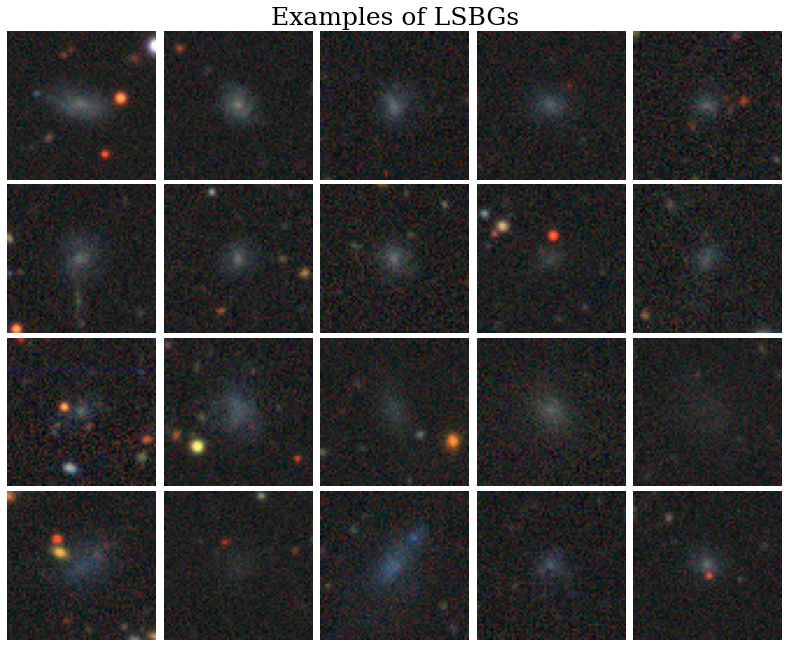

In [ ]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of LSBGs",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_pos[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()

- Plot examples of artifacts

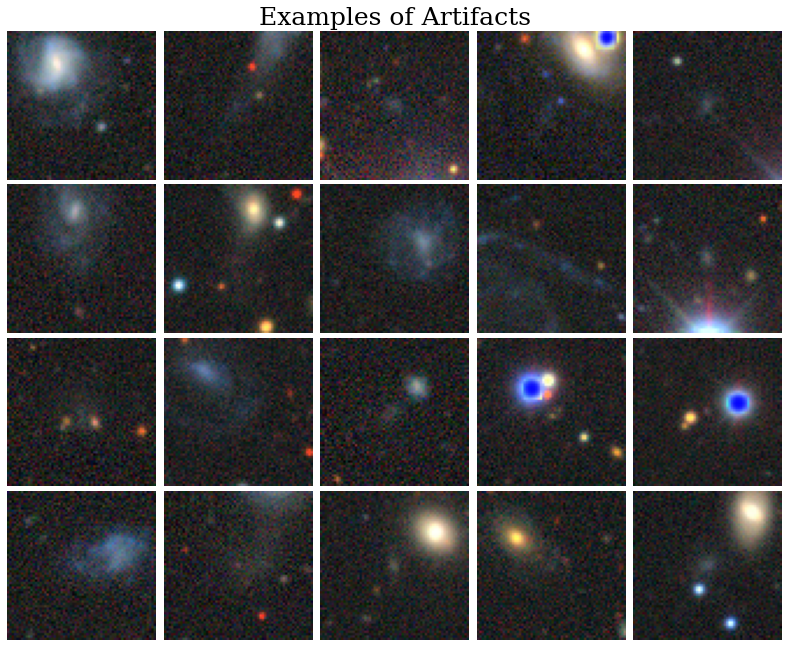

In [ ]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of Artifacts",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_neg[i])
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)
plt.show()

#### Split the dataset into training-validation-test sets.

It is a good practice to split **randomly** the full dataset into a training, avalidation, and a test set (the use of them will become clear in a while).

In [ ]:
# Data
X_tr = X_data[:4000]
X_val = X_data[4000:4500]
X_test = X_data[4500:]
# Labels
y_tr = y_lab[:4000]
y_val = y_lab[4000:4500]
y_test = y_lab[4500:]

## About Neural Networks

Deep Learning and (deep) neural nets are often (always?) synonymous.
Let us briefly discuss the math behind **neural networks**


**Sinlge Neuron**

![Single_Neuron.png](https://drive.google.com/uc?export=view&id=1X8QJLA8qAT-0ya5Ys790pR1IB9_1j7JH)


The building blocks of Artificial Neural Networks (ANNs) are the neurons. We can see a graphical representation of a single neuron above.  A neuron takes as input a vector $\mathbf{x} = (x_1,x_2,\dots,x_m)$ with weights $\mathbf{w}=(w_1,w_2,\dots,w_m)$ and a bias parameter, $b$, and produces an output:
\begin{equation}
y = g(\mathbf{w\cdot x} + b),
\end{equation}
 \\
where $g$ is a function called the **activation function** (or non-linearity). A popular such function is the **rectified linear unit (ReLU)**:
\begin{equation}
g(x)=\mbox{max}(0,x).
\end{equation}

Another common activation function is the **sigmoid**:
\begin{equation}
g(x) = \frac{1}{1+e^{-z}}
\end{equation}

**Deep Neural Nets**

A (feed-forward) deep neural network consists of several layers of neurons, with the outputs of the neurons of the previous layer being the inputs of the neurons of the following one. Let us denote as $\textbf{x}_{n-1}$ the input vector to the $n$-th layer, $\mathbf{W}_n$ is a matrix containing the weights of all the neurons of that layer and $\mathbf{b}_n$ a vector of biases. Then, in analogy to the previous equation, the output of the $n$-th layer is given by: 
\begin{equation}
\mathbf{x}_n = g(\mathbf{W}_n \mathbf{x}_{n-1} + \mathbf{b}_n).
\end{equation}
 \\
![Neural_Network.png](https://drive.google.com/uc?export=view&id=14N9k4yK4Rm6b5oD9ZvmI21d_peEbk2P-)


The final layer is called the **output layer** (the intermediate ones are called hidden) and for a binary classification problem can be just a single neuron. The activation function of the output layer has a sigmoid form, thus the output is a real number between zero and one. 
 \\
 According to the **universal approximation theorem**, a neural network with one hidden layer can approximate any function (a visual proof can be found at http://neuralnetworksanddeeplearning.com/chap4.html).

### Convolutional Neural Networks (CNN): The backbone of Computer Vision


The arrangement we just described has a very large number of trainable parameters (weights) and also it does not
preserve spatial information, so it is not optimal for computer vision tasks.
**Convolutional Neural Networks (CNNs)** were designed to overcome these limitations and were inspired by the way the visual cortex works. The main difference between a fully connected and a convolutional layer is that in the latter the connections happen within a given receptive field.
 \\

Each neuron in a convolutional layer is connected only to neurons within a small rectangle in the previous layer, usually of $3-5$ pixels in size, in each direction.
 \\

If we have $k=1,\dots,K$ input feature maps and $\ell = 1,\dots, L$ output feature maps $\ell$-th output map of the $n$-th layer as:
\begin{equation}
\mathbf{x}_n^{\ell} = g\left(\sum_{k=1} \textbf{W}_n^{k,\ell} * \mathbf{x}_{n-1}^k + b_n^\ell \right),
\end{equation}
where $*$ represents the convolution operation.


Let's some of the elements of a convolutional neural network, starting with the convolution operation:

![convolution.png](https://drive.google.com/uc?export=view&id=1METH_5klGerM-loEJWnFpJ3NJlohwwYR)

The convolutional neural network has a series of filters (generated using different kernels):

![kernels.png](https://drive.google.com/uc?export=view&id=1aCuRm-XeOWoAEyRe8Ew_ps7D9U7ytdpv)

Convolutional layers are always followed by **pooling layers** that prevent overfitting. Here's how they work:

![pooling.png](https://drive.google.com/uc?export=view&id=1N3CYnkDd1EUpn8WGv7gBXYLC2XzeqtUI)

Something else you are going to notice is the **dropout**, which consists of setting to zero a fraction of randomly selected weights. This is also a technique used to prevent **overfitting**. Here is how it works:

![pooling.png](https://drive.google.com/uc?export=view&id=1HPcLc_XzMJJyo_Qc3WT3pt7dmmgvhoF6)


### Let's build a (convolutional) neural network

In [ ]:
# build the Deep Learning 
model = keras.models.Sequential()
model.add(InputLayer((64,64,3)))
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*16, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Conv2D(filters=2*32, kernel_size=(3,3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.13)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(rate=0.4))
model.add(Flatten())
model.add(Dense(units=1024, activation='relu',kernel_regularizer=regularizers.l2(0.12)))
model.add(Dense(units=1, activation='sigmoid'))

**How to train your CNN**

When training a deep learning model, we seek to find a set of weights and biases that minimize a loss function between the predicted and true labels. For binary problems this is usually the cross-entropy: 
\begin{equation}
{\cal{L}}(\mathbf{y},\mathbf{\hat{y}}) = -\frac{1}{N}\sum_{i=1}^N \hat{y}^i \log_2 y^i+(1-\hat{y}^i)\log_2(1-y^i).
\end{equation}
The parameters are updated attractively via gradient descent:
\begin{gather}
\mathbf{W}_n \leftarrow \mathbf{W}_n - \eta \frac{\partial {\cal{L}}}{\partial \mathbf{W}}_n\\
\mathbf{b}_n \leftarrow \mathbf{b}_n - \eta \frac{\partial {\cal{L}}}{\partial \mathbf{b}}_n,
\end{gather}
where $\eta$ $(>0)$ is known as the *learning rate* that controls the magnitude of the update at each step. In practice, only a small sample (mini-batch) is used to update the weights at each step as a way to speed up computation.



![gradient_1.png](https://drive.google.com/uc?export=view&id=1vy-EhMW9kLGNY0YX6O8AdZ2xAbAakHMo)

![gradient_2.png](https://drive.google.com/uc?export=view&id=17GUxNdtrnukFUN6_D_f_tQ4KrpyonmC2)

Note that in practice the learning rate is rarely constant and the gradient decent procedure described here is a "naive" version. Optimizers are being used for a more efficient training, like the Adadelta used above, which assigns different learning rates to different paramters. For a detailed review of gradient descent and the different optimization methods, see: https://ruder.io/optimizing-gradient-descent/.

In [ ]:
model.compile(optimizer=optimizers.Adadelta(learning_rate=0.1),
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
n_epochs = 60 # Number of epochs

model.fit(x=X_tr, y=y_tr,
          epochs=n_epochs, batch_size=64,
          shuffle=True,
          validation_data=(X_val,y_val))

Epoch 1/60
63/63 [==============================] - 14s 20ms/step - loss: 168.2024 - accuracy: 0.6633 - val_loss: 133.0269 - val_accuracy: 0.4940
Epoch 2/60
63/63 [==============================] - 1s 12ms/step - loss: 107.9643 - accuracy: 0.7680 - val_loss: 85.5688 - val_accuracy: 0.4940
Epoch 3/60
63/63 [==============================] - 1s 12ms/step - loss: 69.2113 - accuracy: 0.8002 - val_loss: 54.6472 - val_accuracy: 0.8320
Epoch 4/60
63/63 [==============================] - 1s 14ms/step - loss: 43.9589 - accuracy: 0.8158 - val_loss: 34.9629 - val_accuracy: 0.4940
Epoch 5/60
63/63 [==============================] - 1s 15ms/step - loss: 27.7616 - accuracy: 0.8285 - val_loss: 21.9229 - val_accuracy: 0.5460
Epoch 6/60
63/63 [==============================] - 1s 13ms/step - loss: 17.5055 - accuracy: 0.8410 - val_loss: 14.0137 - val_accuracy: 0.5580
Epoch 7/60
63/63 [==============================] - 1s 12ms/step - loss: 11.1557 - accuracy: 0.8512 - val_loss: 9.1992 - val_accuracy: 0.5

### Evaluation

We can't go on without evaluating the performance of the model.

We start (always by printing the learning curves)


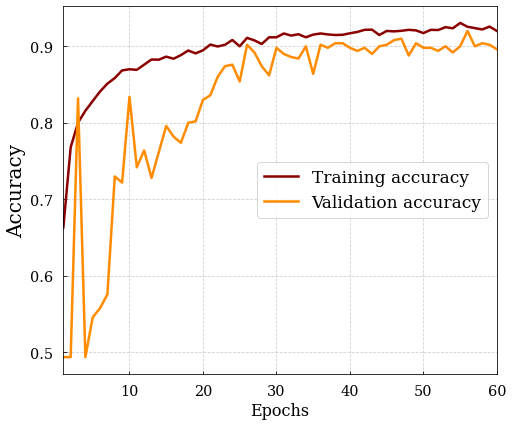

In [ ]:
Epochs = np.arange(1,n_epochs+1,1)
history_dict = model.history.history

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_err = 1.0 - np.asarray(train_acc)
val_err = 1.0 - np.asarray(val_acc)

# =====================================================================
# =====================================================================
plt.figure(figsize=(7.2, 6.0))

# Plot Accuracy
plt.plot(Epochs, train_acc, c = 'darkred',linewidth=2.5,label='Training accuracy')
plt.plot(Epochs, val_acc , c = 'darkorange',linewidth=2.5,label='Validation accuracy')
# Plot Loss
#plt.plot(Epochs, train_loss, c = 'mediumblue',linewidth=2.5,label='Training loss')
#plt.plot(Epochs, val_loss , c = 'dodgerblue',linewidth=2.5,label='Validation loss')

# =====================================================================
plt.grid(ls='--',alpha=0.6)
plt.xlabel('Epochs', fontsize=16);plt.ylabel('Accuracy',fontsize=20)
plt.xlim(1,n_epochs)
#plt.ylim(0.2,1)
plt.legend(frameon=True, loc='center right', fontsize=17)
plt.tick_params(axis='both', labelsize=14.5)


#plt.xlim(10,);plt.ylim(0,2)
plt.tight_layout()
plt.show()

**Plot confusion matrix**

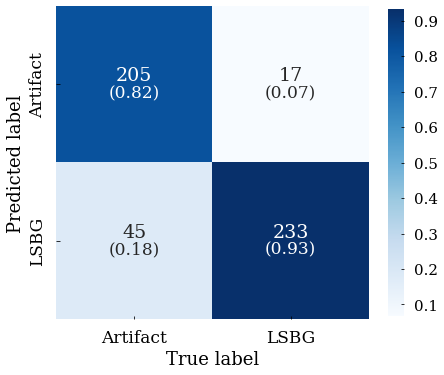

In [ ]:
# Predict on test data 
scores = model.predict(X_test)

# What if we change that?
y_pred_CNN =  (scores > 0.5).astype("int32")

# Get the confusion matrix for the Deep Learning
con_mat_DL = confusion_matrix(y_test, y_pred_CNN)

# Get annotations and normalized confusion matrix
a = con_mat_DL[0]/np.sum(con_mat_DL[0])
b = con_mat_DL[1]/np.sum(con_mat_DL[1])


con_mat_normalized = np.zeros([2,2])
con_mat_normalized[0] = a
con_mat_normalized[1] = b

# Annotations
an_1 = "("+"{:.2f}".format(a[0])+")"
an_2 = "("+"{:.2f}".format(a[1])+")"
an_3 = "("+"{:.2f}".format(b[0])+")"
an_4 = "("+"{:.2f}".format(b[1])+")"

annots = np.zeros([2,2],dtype='U6')

annots[0,0] = an_1;annots[0,1] = an_2
annots[1,0] = an_3;annots[1,1] = an_4

class_names = ['Artifact','LSBG']
# ==============================================
# ==============================================


plt.figure(figsize = (7,6.0))
g =sns.heatmap(con_mat_DL.T, square = True, annot=True,annot_kws={'va':'bottom',"size": 19},fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)
sns.heatmap(con_mat_normalized.T, square=True, annot=annots.T, annot_kws={'va':'top',"size": 17},cmap='Blues',fmt='', cbar=True,
            cbar_kws={'shrink':0.94})
g.set_xticklabels(class_names, fontsize = 17)
g.set_yticklabels(class_names, fontsize = 17)

# Ticks for colorbar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
# =========================================
# =========================================
plt.xlabel('True label',fontsize=18)
plt.ylabel('Predicted label',fontsize=18)
plt.show()

### **Beyond classification: Object Detection**

CNN forms the basis of many modern (deep learning-based) **object detection** algorithms.

For example Mask R-CNN and object detection and segmentation algorithm developed by Facebook AI Research (arXiv: 1703.06870)

![Mask_rcnn](https://drive.google.com/uc?export=edit&id=11MJPoqnHFZbb1VC2U_2PFAlAYHwaCYJ-)


Mask R-CNN has a CNN network as its **backbone**: 

<div>
<img src=https://drive.google.com/uc?export=edit&id=1W7lDCppozhTnjfp7j2rzPDzqyn5jprGz width="560">
<div>

### **Application in astrophysics**

"Cleaning" astronomical images from spurious reflections (arXiv: 2109.08246).

<div>
<img src=https://drive.google.com/uc?export=view&id=1WFhxQlW6X214ym1qgYaEp6KD1mK1K4c8 width="560">
<div>







<div>
<img src=https://drive.google.com/uc?export=view&id=16hdnvz_IzrkeU3STICPB6v4a4TGMarHD width="860">
<div>

